In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display as dsp
from IPython.display import Audio
from tqdm import tqdm
import math

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
def get_audio(digit=0):
    # Audio Sample Directory
    sample = np.random.randint(1,60)
    # Index of Audio
    index = np.random.randint(1,50)

    # Modified file location
    if sample<10:
        file = f"/content/drive/MyDrive/mnist_audio/data/0{sample}/{digit}_0{sample}_{index}.wav"
    else:
        file = f"/content/drive/MyDrive/mnist_audio/data/{sample}/{digit}_{sample}_{index}.wav"


    # Get Audio from the location
    data,sample_rate = librosa.load(file)

    # Plot the audio wave
    dsp.waveshow(data,sr=sample_rate)
    plt.show()

    # Show the widget
    return Audio(data=data,rate=sample_rate)

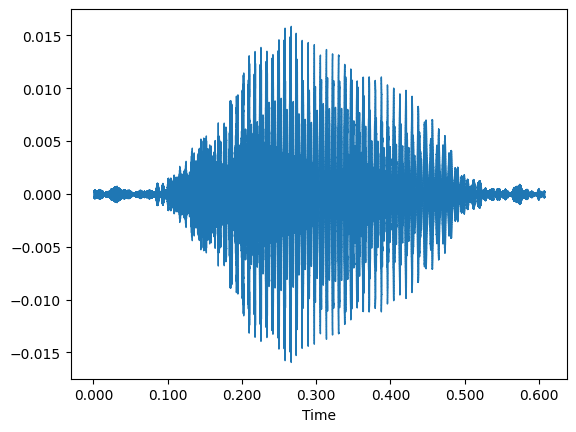

In [5]:
# Show the audio and plot of digit 0
get_audio(0)

In [6]:
def get_audio_raw(digit=0):
    # Audio Sample Directory
    sample = np.random.randint(1,60)
    # Index of Audio
    index = np.random.randint(1,5)

    # Modified file location
    if sample<10:
        file = f"/content/drive/MyDrive/mnist_audio/data/0{sample}/{digit}_0{sample}_{index}.wav"
    else:
        file = f"/content/drive/MyDrive/mnist_audio/data/{sample}/{digit}_{sample}_{index}.wav"


    # Get Audio from the location
    data,sample_rate = librosa.load(file)

    # Return audio
    return data,sample_rate

In [7]:
def spectogram_of(digit):
    # Read the audio file
    data,sr = get_audio_raw(digit)
    # Apply Short-Time-Fourier-Transformer to transform data
    D = librosa.stft(data)
    # Converting frequency to decible
    S_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)
    # Plot the transformed data
    librosa.display.specshow(S_db,x_axis='time',y_axis='log')
    plt.show()

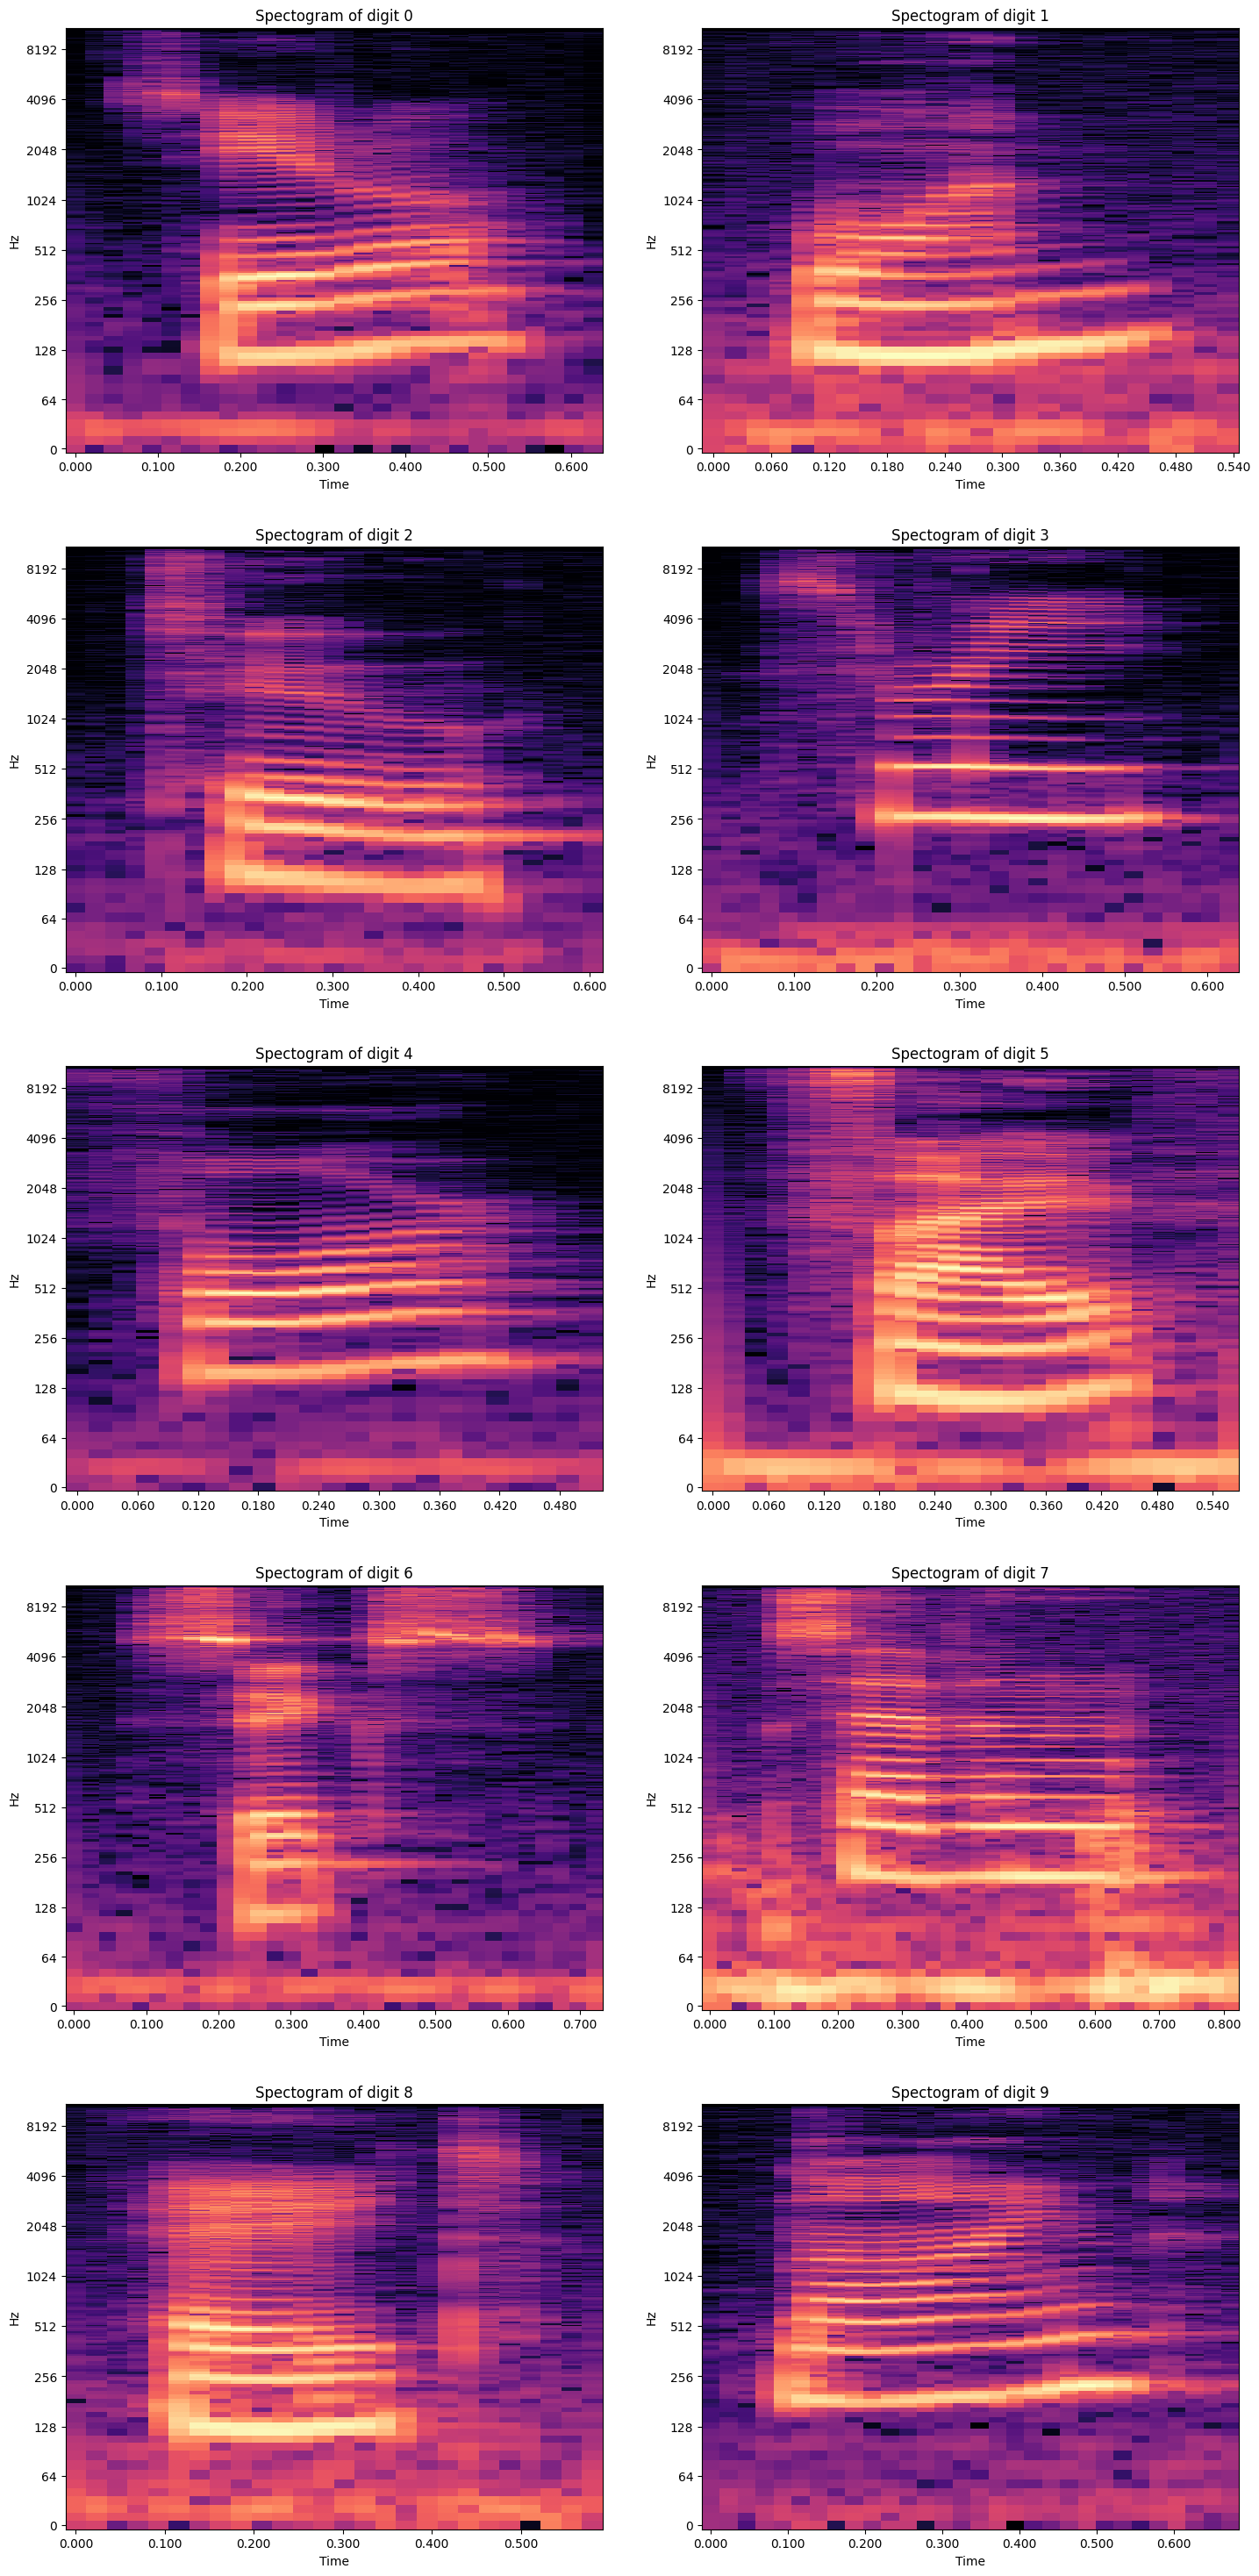

In [ ]:
fig,ax = plt.subplots(5,2,figsize=(15,30))

# Initializing row and column variables for subplots
row = 0
column = 0

for digit in range(10):
    # Read the audio file
    data,sr = get_audio_raw(digit)
    # Apply Short-Time-Fourier-Transformer to transform data
    D = librosa.stft(data)
    # Converting frequency to decible
    S_db = librosa.amplitude_to_db(np.abs(D),ref=np.max)
    # Plot the transformed data
    ax[row,column].set_title(f"Spectogram of digit {digit}")
    librosa.display.specshow(S_db,x_axis='time',y_axis='log',ax=ax[row,column])

    # Conditions for positioning of the plots
    if column == 1:
        column = 0
        row += 1
    else:
        column+=1


plt.tight_layout(pad=3)
plt.show()

In [ ]:
def before(voice):
  this = []
  h = np.array([0]*22050)
  voice = np.concatenate((h,voice),axis=0)
  voice = ((librosa.amplitude_to_db(np.abs(librosa.stft(voice[-22050:],n_fft = 2048 ,hop_length = 256)),ref=np.max)+80)/10)**2/60
  for n in range(87):
    a = np.zeros([1000])
    h = 0
    i = 1
    j = 1
    a[0] = np.mean(voice[0:math.floor(2**(h+1/10)),n])
    while math.floor(2**((j+h+1)/10))<=1025:
      if math.floor(2**((j+h)/10)) == math.floor(2**((j+h+1)/10)):
        i = i - 1
      else:
        a[i] = np.mean(voice[math.floor(2**((j+h)/10)):math.floor(2**((j+h+1)/10)),n])
      j = j+1
      i = i+1
    this.append(a[:i])
  return np.array(this).reshape(1,87,-1)

(87, 75)


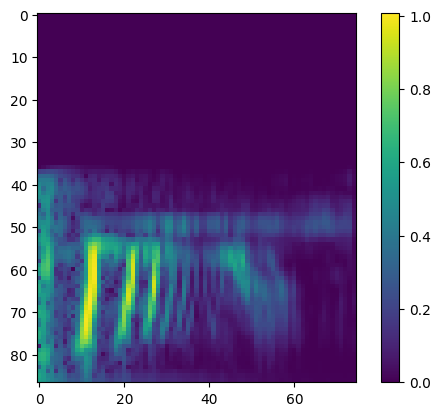

In [ ]:
voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/0{2}/{3}_0{2}_{7}.wav')
voice = before(voice).reshape(87,-1)
print(voice.shape)
plt.imshow(voice, cmap='viridis', interpolation='nearest')
plt.colorbar()  # 컬러바 추가
plt.show()

In [ ]:
class Cnn_Model(nn.Module):
    def __init__(self):
        super(Cnn_Model, self).__init__()
        self.conv0 = nn.Conv2d(1, 128, kernel_size=3, stride=1)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1)
        self.fc0 = nn.Linear(128 * 19 * 16, 128)
        self.fc2 = nn.Linear(128, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu(self.conv0(x))
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc0(x))
        x = self.softmax(self.fc2(x))
        #x = self.fc2(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Cnn_Model().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-5)
criter = nn.CrossEntropyLoss()

In [ ]:
def training():
    number = np.random.randint(0, 10, size=8)
    who = np.random.randint(1, 51, size=8)
    order = np.random.randint(0, 50, size=8)
    input = []
    target = []
    for i in range(8):
        if who[i] < 10:
            voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/0{who[i]}/{number[i]}_0{who[i]}_{order[i]}.wav')
        else:
            voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/{who[i]}/{number[i]}_{who[i]}_{order[i]}.wav')

        input.append(before(voice))
        target.append(number[i])

    input = np.array(input)
    target = np.array(target)

    input = torch.tensor(input, dtype=torch.float32)
    input = input.to(device)

    target = torch.tensor(target, dtype=torch.long)  # CrossEntropyLoss를 위해 타겟을 long 형식으로 변환
    target = target.to(device)

    output = model(input)
    loss = criter(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    accuracy = torch.sum(torch.argmax(output,dim=1) == target)/8

    return (loss, accuracy)

In [ ]:
for i in range(10):
  losss, accuracys = training()
  for j in tqdm(range(19),colour="green"):
    a, b = training()
    losss = losss+a
    accuracys = accuracys+b
  print(losss/20)
  print(accuracys/20)

100%|██████████| 19/19 [00:36<00:00,  1.93s/it]


tensor(1.5689, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9250, device='cuda:0')


100%|██████████| 19/19 [00:34<00:00,  1.84s/it]


tensor(1.5810, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8938, device='cuda:0')


100%|██████████| 19/19 [00:35<00:00,  1.89s/it]


tensor(1.5634, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9187, device='cuda:0')


100%|██████████| 19/19 [00:32<00:00,  1.69s/it]


tensor(1.5985, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8875, device='cuda:0')


100%|██████████| 19/19 [00:34<00:00,  1.81s/it]


tensor(1.5991, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8625, device='cuda:0')


100%|██████████| 19/19 [00:34<00:00,  1.84s/it]


tensor(1.5726, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9000, device='cuda:0')


100%|██████████| 19/19 [00:35<00:00,  1.85s/it]


tensor(1.5802, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9062, device='cuda:0')


100%|██████████| 19/19 [00:33<00:00,  1.76s/it]


tensor(1.6020, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.8813, device='cuda:0')


100%|██████████| 19/19 [00:34<00:00,  1.82s/it]


tensor(1.5690, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9125, device='cuda:0')


100%|██████████| 19/19 [00:33<00:00,  1.76s/it]

tensor(1.5414, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.9250, device='cuda:0')


In [ ]:
voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/0{2}/{1}_0{2}_{7}.wav')
voice = before(voice).reshape(1,1,87,75)
voice = torch.tensor(voice, dtype=torch.float32)
voice = voice.to(device)
print(model(voice))

tensor([[3.1452e-05, 9.9912e-01, 1.8747e-06, 1.7408e-05, 1.4452e-05, 2.3362e-05,
         2.0549e-08, 5.8962e-04, 5.9938e-08, 1.9871e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/0{2}/{1}_0{2}_{7}.wav')
voice = before(voice).reshape(1,1,87,75)
voice = torch.tensor(voice, dtype=torch.float32)
voice = voice.to(device)
print(model(voice))

tensor([[3.1452e-05, 9.9912e-01, 1.8747e-06, 1.7408e-05, 1.4452e-05, 2.3362e-05,
         2.0549e-08, 5.8962e-04, 5.9938e-08, 1.9871e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
torch.save(model, '/content/drive/MyDrive/mnist_audio/cnn_model_weights.pth')

In [ ]:
model = torch.load('/content/drive/MyDrive/mnist_audio/cnn_model_weights.pth', map_location=device)

In [ ]:
number = np.arange(10)
who = np.arange(51,61)
order = np.arange(50)
#10*10*50 == 5000
c = 0
for answer in tqdm(number,colour='green'):
  for w in who:
    for o in order:
      if w < 10:
         voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/0{w}/{answer}_0{w}_{o}.wav')
      else:
         voice, sr = librosa.load(f'/content/drive/MyDrive/mnist_audio/data/{w}/{answer}_{w}_{o}.wav')
      voice = np.array([before(voice)])
      voice = torch.tensor(voice, dtype=torch.float32)
      voice = voice.to(device)
      my_answer = torch.argmax(model(voice),dim=1)

      if my_answer == answer:
        c = c + 1

100%|██████████| 10/10 [26:23<00:00, 158.35s/it]


In [ ]:
print(c/5000)

0.9186
